In [1]:
#출처:https://seokii.tistory.com/142
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from sklearn.model_selection import train_test_split

from konlpy.tag import Komoran

In [2]:
train = pd.read_table('ratings_train.txt')
test = pd.read_table('ratings_test.txt')

In [3]:
train.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [4]:
test.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [5]:
print(f"train shape => {train.shape} \ntest shape =>{test.shape}")

train shape => (150000, 3) 
test shape =>(50000, 3)


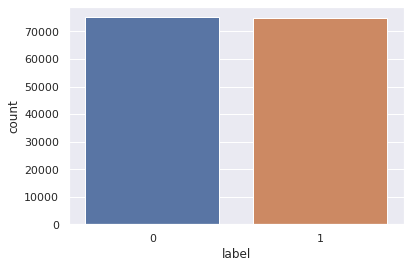

In [6]:
#라벨값의 수 시각화
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="label", data=train)

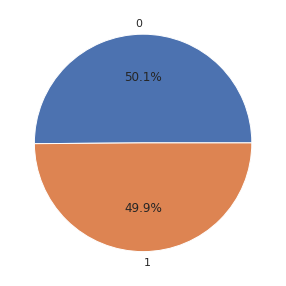

In [7]:
#라벨값의 비율 시각화
labels, frequencies = np.unique(train.label.values, return_counts=True)
plt.figure(figsize=(5,5))
plt.pie(frequencies, labels = labels, autopct = '%1.1f%%')
plt.show()


In [8]:
#결측값 확인
train.isnull().sum()

id          0
document    5
label       0
dtype: int64

In [9]:
test.isnull().sum()

id          0
document    3
label       0
dtype: int64

In [14]:
tokenizer = Komoran()

def preprocess(train, test):
    train.drop_duplicates(subset=['document'], inplace=True)
    test.drop_duplicates(subset=['document'], inplace = True)
    train = train.dropna()
    test = test.dropna()
    print(f"train shape => {train.shape} \ntest shape =>{test.shape}")
    
    train_tokenized = [[token+"/"+POS for token, POS in tokenizer.pos(doc_)] for doc_ in train['document']]
    test_tokenized = [[token+"/"+POS for token, POS in tokenizer.pos(doc_)] for doc_ in test['document']]
    
    exclusion_tags = ['JKS', 'JKC', 'JKG', 'JKO', 'JKB', 'JKV', 'JKQ', 'JX', 'JC',
                        'SF', 'SP', 'SS', 'SE', 'SO', 'EF', 'EP', 'EC', 'ETN', 'ETM',
                     'XSN', 'XSV', 'XSA']
    f = lambda x: x in exclusion_tags
    
    X_train = []
    for i in range(len(train_tokenized)):
        temp = []
        for j in range(len(train_tokenized[i])):
            if f(train_tokenized[i][j].split('/')[1]) is False:
                temp.append(train_tokenized[i][j].split('/')[0])
        X_train.append(temp)

    X_test = []
    for i in range(len(test_tokenized)):
        temp = []
        for j in range(len(test_tokenized[i])):
            if f(test_tokenized[i][j].split('/')[1]) is False:
                temp.append(test_tokenized[i][j].split('/')[0])                
        X_test.append(temp)
                            
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(30000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    return X_train, np.array(list(train['label'])), X_test, np.array(list(test['label'])), word_to_index

In [15]:
X_train, y_train, X_test, y_test, word_to_index = preprocess(train, test)

train shape => (146182, 3) 
test shape =>(49157, 3)


In [17]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [19]:
all_data = list(X_train)+list(X_test)

num_tokens = [len(tokens) for tokens in all_data]
num_tokens = np.array(num_tokens)

#평균, 최대, 표준편차
print(f"토큰 길이 평균: {np.mean(num_tokens)}")
print(f"토큰 길이 최대: {np.max(num_tokens)}")
print(f"토큰 길이 표준편차: {np.std(num_tokens)}")

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print(f'설정 최대 길이: {maxlen}')
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 설정값인 {maxlen}에 포합됩니다.')

토큰 길이 평균: 10.763011994532581
토큰 길이 최대: 140
토큰 길이 표준편차: 8.886926944778248
설정 최대 길이: 28
전체 문장의 0.9356554502685076%가 설정값인 28에 포합됩니다.


In [23]:
#패딩
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                       padding='pre',
                                                       value=word_to_index["<PAD>"],
                                                       maxlen=70)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                      padding='pre',
                                                      value=word_to_index["<PAD>"],
                                                      maxlen=70)

In [26]:
#모델링(LSTM)
vocab_size = 30000
word_vector_dim = 16

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(units=8))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          480000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 480,809
Trainable params: 480,809
Non-trainable params: 0
_________________________________________________________________


In [27]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True,
                                                 stratify=y_train, random_state=777)

In [28]:
history = model.fit(X_train, y_train, epochs=10, batch_size=512,
                   validation_data=(X_val, y_val), verbose=1)

Epoch 1/10
229/229 [==============================] - 6s 25ms/step - loss: 0.5403 - accuracy: 0.7743 - val_loss: 0.4211 - val_accuracy: 0.8229
Epoch 2/10
229/229 [==============================] - 5s 22ms/step - loss: 0.3739 - accuracy: 0.8434 - val_loss: 0.3820 - val_accuracy: 0.8322
Epoch 3/10
229/229 [==============================] - 5s 23ms/step - loss: 0.3311 - accuracy: 0.8644 - val_loss: 0.3793 - val_accuracy: 0.8321
Epoch 4/10
229/229 [==============================] - 5s 23ms/step - loss: 0.3076 - accuracy: 0.8757 - val_loss: 0.3822 - val_accuracy: 0.8309
Epoch 5/10
229/229 [==============================] - 5s 22ms/step - loss: 0.2909 - accuracy: 0.8838 - val_loss: 0.3890 - val_accuracy: 0.8315
Epoch 6/10
229/229 [==============================] - 5s 22ms/step - loss: 0.2775 - accuracy: 0.8909 - val_loss: 0.3979 - val_accuracy: 0.8293
Epoch 7/10
229/229 [==============================] - 5s 22ms/step - loss: 0.2655 - accuracy: 0.8963 - val_loss: 0.4041 - val_accuracy: 0.8271

In [29]:
predict = model.evaluate(X_test, y_test, verbose=1)
print(predict)

1537/1537 [==============================] - 16s 11ms/step - loss: 0.4299 - accuracy: 0.8278
[0.4298862814903259, 0.8277559876441956]


In [32]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


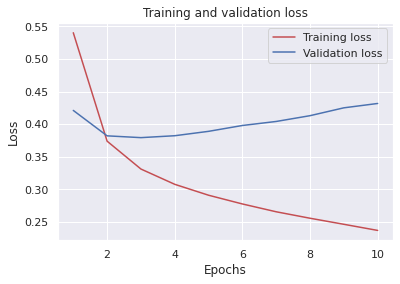

In [33]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()